# 

# Prever se uma ação vai subir ou descer

### Entendendo o problema

In [30]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import os 
os.environ["KERAS_BACKEND"] = "tensorflow" 

from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None

import seaborn as sns

In [2]:
# Dados das ações

acao = "^BVSP" # Ibovespa

inicio = "2014-12-31"
final = "2024-04-20"

dados_acao = yf.download(acao, inicio, final)

dados_acao

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900
...,...,...,...,...,...,...
2024-04-15,125946.0,126250.0,125034.0,125334.0,125334.0,13504500
2024-04-16,125316.0,125316.0,123756.0,124389.0,124389.0,14009800
2024-04-17,124389.0,125301.0,123642.0,124171.0,124171.0,11370900


### Análise Exploratória

In [3]:
dados_acao.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100
2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100
2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300
2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800
2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900


In [4]:
dados_acao.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-15,125946.0,126250.0,125034.0,125334.0,125334.0,13504500
2024-04-16,125316.0,125316.0,123756.0,124389.0,124389.0,14009800
2024-04-17,124389.0,125301.0,123642.0,124171.0,124171.0,11370900
2024-04-18,124171.0,125140.0,123397.0,124196.0,124196.0,10662400
2024-04-19,124197.0,125509.0,124056.0,125124.0,125124.0,13604100


In [5]:
# Verificando o tamanho da base
dados_acao.shape

(2304, 6)

In [6]:
# Verificando o resumo das informações da base de dados
dados_acao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2304 entries, 2015-01-02 to 2024-04-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2304 non-null   float64
 1   High       2304 non-null   float64
 2   Low        2304 non-null   float64
 3   Close      2304 non-null   float64
 4   Adj Close  2304 non-null   float64
 5   Volume     2304 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 126.0 KB


In [7]:
# Contando a quantidade de valores nulos
dados_acao.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# Verificando as informações estatísticas
dados_acao.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2.304000e+03
mean,89427.140625,90261.345052,88614.953559,89458.071615,89458.071615,7.109668e+06
std,26095.446831,26228.746174,25943.791292,26092.042868,26092.042868,4.320895e+06
min,37501.000000,38031.000000,37046.000000,37497.000000,37497.000000,0.000000e+00
25%,64700.250000,65320.750000,64164.500000,64713.250000,64713.250000,3.537575e+06
50%,96529.500000,97534.000000,95571.500000,96548.000000,96548.000000,5.340850e+06
75%,111834.000000,112905.000000,110676.000000,111816.500000,111816.500000,1.056692e+07
max,134194.000000,134392.000000,133832.000000,134194.000000,134194.000000,2.602930e+07


**A cardinalidade nos ajuda a saber a quantidade de dados distintos em uma coluna**
- Se tivermos muitos valores distintos, provavelmente aquela coluna não será uma boa opção para usarmos no modelo;
- Matemáticamente, cardinalidade é o número de elementos de um conjunto/coluna;
- Podemos verificar a cardinalidade usando o .nunique();

In [9]:
# Verificando o número de valores únicos
dados_acao.nunique()
# Em tese todas as colunas seriam ruins para o treinamento

Open         2267
High         2261
Low          2266
Close        2263
Adj Close    2263
Volume       2249
dtype: int64

(array([ 34.,  72., 175., 101., 101., 138.,  56., 104., 106., 106.,  53.,
         71., 153., 205., 178., 206., 221.,  78., 105.,  41.]),
 array([ 37497.  ,  42331.85,  47166.7 ,  52001.55,  56836.4 ,  61671.25,
         66506.1 ,  71340.95,  76175.8 ,  81010.65,  85845.5 ,  90680.35,
         95515.2 , 100350.05, 105184.9 , 110019.75, 114854.6 , 119689.45,
        124524.3 , 129359.15, 134194.  ]),
 <BarContainer object of 20 artists>)

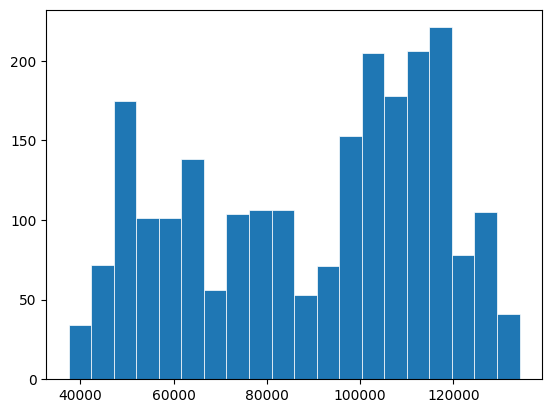

In [10]:
# Visualizando os dados com MatPlotlib

x = dados_acao.Close # Dados de fechamento

# plot
fig, ax = plt.subplots()

ax.hist(x, bins=20, linewidth=0.5, edgecolor='white')

/home/leandro/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/leandro/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

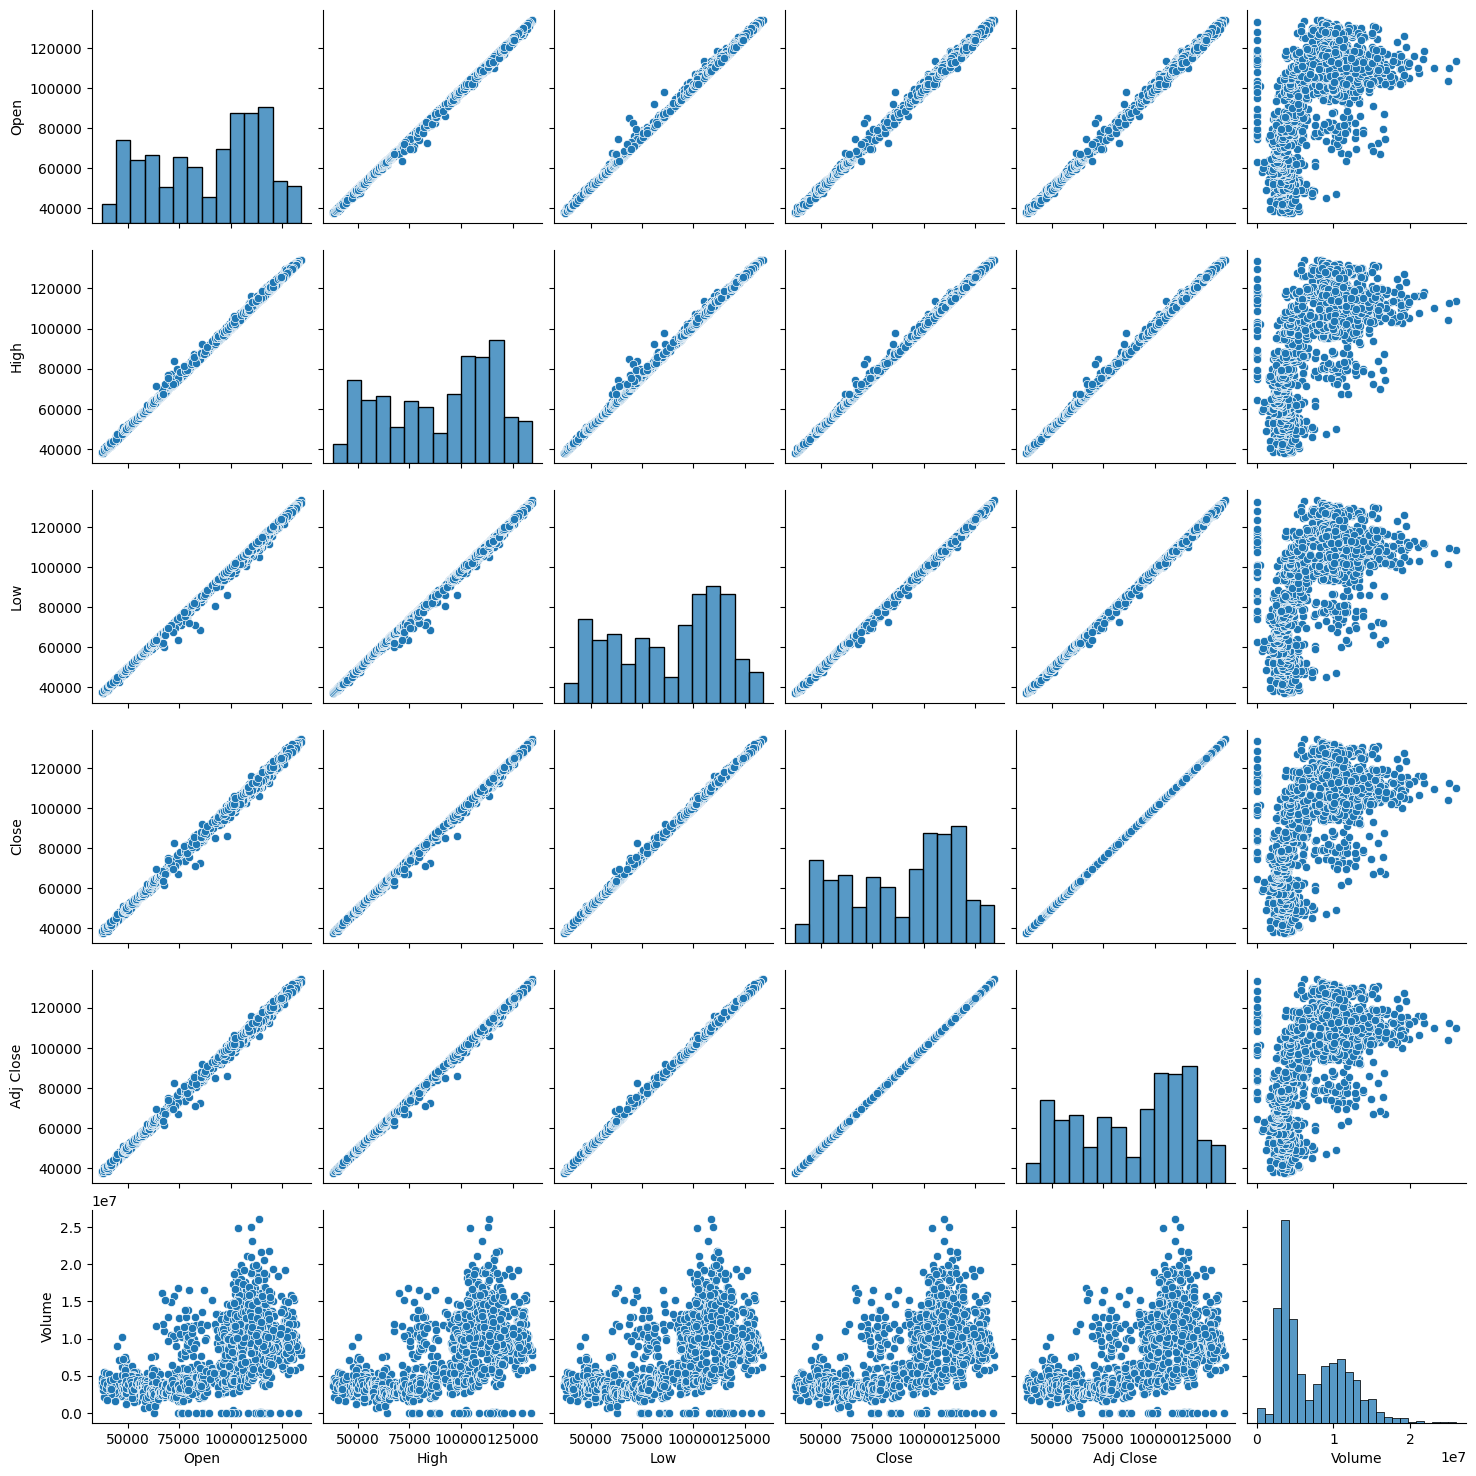

In [11]:
sns.pairplot(dados_acao)

In [12]:
# Correlação entre as variáveis

dados_acao.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999479,0.999196,0.998704,0.998704,0.645659
High,0.999479,1.000000,0.999254,0.999425,0.999425,0.652085
Low,0.999196,0.999254,1.000000,0.999569,0.999569,0.639441
Close,0.998704,0.999425,0.999569,1.000000,1.000000,0.645720
Adj Close,0.998704,0.999425,0.999569,1.000000,1.000000,0.645720
Volume,0.645659,0.652085,0.639441,0.645720,0.645720,1.000000


### preparação dos dados

In [14]:
# Pegar as cotações de fechamento (preço real da ação)

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[ 48512.],
       [ 47517.],
       [ 48001.],
       ...,
       [124171.],
       [124196.],
       [125124.]])

In [15]:
# Treinar 80% e testar 20% dos dados

tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1843

In [16]:
# Escalar os dados entre 0 e 1, para deixar mais fácil o processamento

escalador = MinMaxScaler(feature_range=(0, 1))

dados_de_escala_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_de_escala_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_de_escala = list(dados_de_escala_treinamento.reshape(len(dados_de_escala_treinamento))) + list(dados_de_escala_teste.reshape(len(dados_de_escala_teste)))

dados_de_escala = np.array(dados_de_escala).reshape(len(dados_de_escala), 1)

dados_de_escala

array([[0.1180866 ],
       [0.10741968],
       [0.11260841],
       ...,
       [0.92919092],
       [0.92945894],
       [0.93940758]])

In [17]:
# Treinamento (Vamos prever os próximos dois meses(60 dias))

dados_para_treinamento = dados_de_escala[0: tamanho_dados_treinamento, :]

# Dados que serão usados para gerar o resultado
treinamento_x = []
# Cotação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):
    # Ultimos 60 dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    # Cotaçao
    treinamento_y.append(dados_para_treinamento[i, 0])
    
    if i <= 61:
        print(treinamento_x)
        print(treinamento_y)


[array([0.1180866 , 0.10741968, 0.11260841, 0.12828182, 0.13342767,
       0.12160293, 0.11409856, 0.11304795, 0.10880262, 0.11287642,
       0.12350047, 0.11000332, 0.11127907, 0.12571962, 0.12806741,
       0.1209061 , 0.11878343, 0.11893352, 0.10932793, 0.11004621,
       0.10089088, 0.10885623, 0.12293228, 0.1265451 , 0.12582682,
       0.12108835, 0.12742418, 0.11806516, 0.11517062, 0.12903226,
       0.140857  , 0.14776102, 0.14791111, 0.14731076, 0.14777174,
       0.15412901, 0.15345362, 0.15291759, 0.15100934, 0.1449844 ,
       0.14801831, 0.13905595, 0.13795174, 0.13383505, 0.12525863,
       0.11573881, 0.12231049, 0.12203175, 0.11898712, 0.1216887 ,
       0.13709409, 0.15039827, 0.14426613, 0.15512602, 0.15449351,
       0.15018386, 0.15395748, 0.14025665, 0.13505719, 0.14736436])]
[0.14636734956421066]
[array([0.1180866 , 0.10741968, 0.11260841, 0.12828182, 0.13342767,
       0.12160293, 0.11409856, 0.11304795, 0.10880262, 0.11287642,
       0.12350047, 0.11000332, 0.111

In [18]:
# Transformando as listas em arrays e dando reshape 3d

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)
treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

Criar um modelo com 50 neurônios

In [19]:
# Criando o Modelo
# return sequences-> True pois será utlizado outro modelo de LSTM
# Adicionando neurônios com o dense, 25 e 1
# Essa é uma das arquiteturas de deep learning (Bem que o Sergio podia pular logo para esse conteúdo)

modelo = Sequential()

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

/home/leandro/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

Copilando o modelo

A função de loss é a forma de medir o erro do modelo, que nesse caso é o classico erro médio quadrático que é usado em regressão linear

In [20]:
modelo.compile(optimizer="adam", loss="mean_squared_error") # least squares

In [21]:
# Treinamento
# Batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros
# Epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1783/1783 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0057


In [22]:
# Criar dados de teste
dados_teste = dados_de_escala[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [23]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [24]:
# Pegando predições do modelo
predicoes = modelo.predict(teste_x)

# Tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes # Reconvertando os dados originais

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[105646.71 ],
       [104456.67 ],
       [103150.29 ],
       [102004.914],
       [101088.94 ],
       [100409.24 ],
       [ 99747.03 ],
       [ 99295.7  ],
       [ 99332.66 ],
       [ 99588.35 ],
       [ 99788.08 ],
       [ 99782.234],
       [ 99740.52 ],
       [ 99631.19 ],
       [ 99455.99 ],
       [ 99333.51 ],
       [ 99548.336],
       [ 99827.93 ],
       [ 99795.34 ],
       [ 99625.28 ],
       [ 99345.1  ],
       [ 98784.945],
       [ 98229.7  ],
       [ 97802.58 ],
       [ 97694.92 ],
       [ 97767.5  ],
       [ 98036.664],
       [ 98352.375],
       [ 98850.305],
       [ 99291.63 ],
       [ 99892.45 ],
       [100652.08 ],
       [101462.91 ],
       [102039.3  ],
       [102584.41 ],
       [103084.17 ],
       [103797.88 ],
       [104588.33 ],
       [105587.76 ],
       [106572.586],
       [107641.89 ],
       [108506.52 ],
       [109599.4  ],
       [110663.664],
       [111624.5  ],
       [112411.94 ],
       [113002.555],
       [11304

In [25]:
# Pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse # A resposta é o erro na moeda real

398.24520404013015

In [26]:
# Criando o gráfico do modelo

treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:], "predicoes": predicoes.reshape(len(predicoes))})

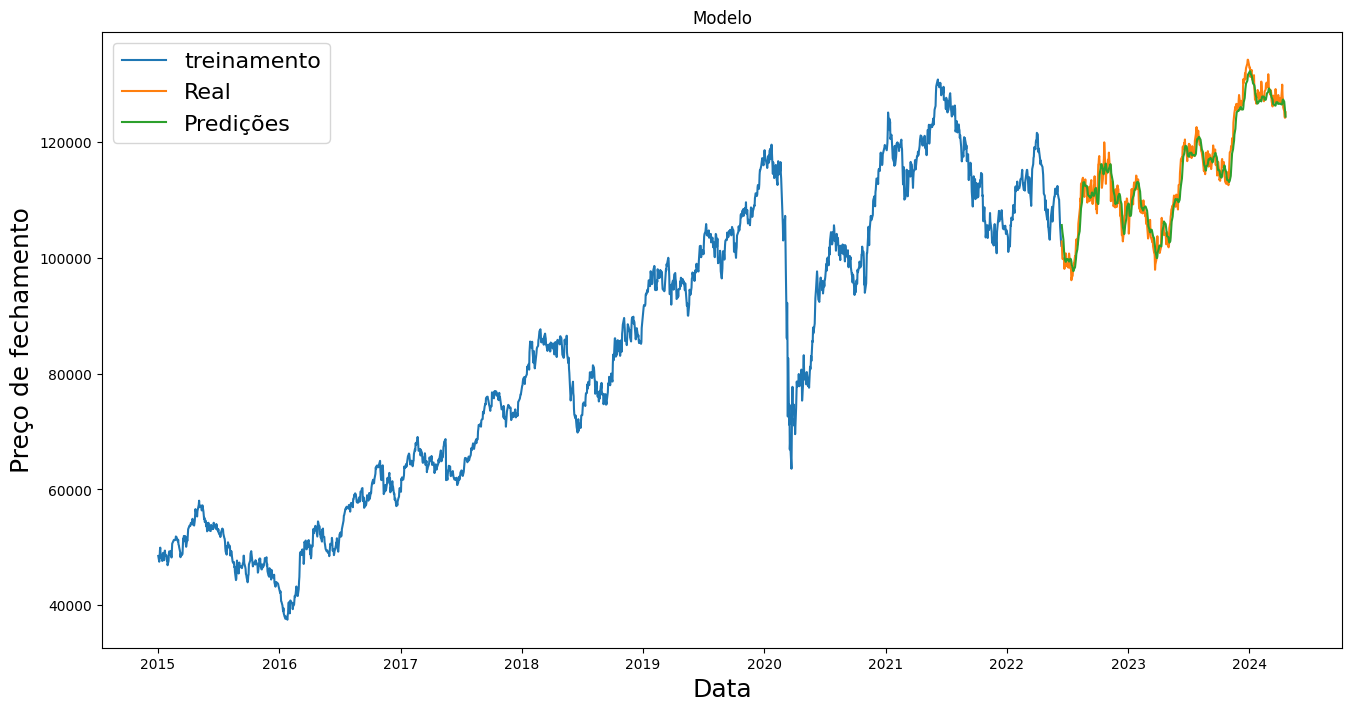

In [27]:
plt.figure(figsize=(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [28]:
df_teste.sort_index()
df_teste

,Close,predicoes
Date,,
2022-06-15,102807.0,105646.710938
2022-06-17,99825.0,104456.671875
2022-06-20,99853.0,103150.289062
2022-06-21,99685.0,102004.914062
2022-06-22,99522.0,101088.937500
...,...,...
2024-04-15,125334.0,126955.570312
2024-04-16,124389.0,126409.335938
2024-04-17,124171.0,125697.609375


https://www.youtube.com/watch?v=QSR0RCC3Mes&ab_channel=BrennoSullivan-VAROSQuant

https://medium.com/turing-talks/turing-talks-27-modelos-de-predi%C3%A7%C3%A3o-lstm-df85d87ad210